# Random Forest

# Model 1
<h7> Using the data columns that produced the best outcome in logistic regression

In [184]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sqlalchemy import create_engine
from database_info import NAME, USER, PASSWORD, HOST, PORT

In [185]:
# Connect to the sql database
DATABASES = {
    'production':{
        'NAME': NAME,
        'USER': USER,
        'PASSWORD': PASSWORD,
        'HOST': HOST,
        'PORT': PORT,
    },
}

# choose the database to use
db = DATABASES['production']

# construct an engine connection string
engine_string = "postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}".format(
    user = db['USER'],
    password = db['PASSWORD'],
    host = db['HOST'],
    port = db['PORT'],
    database = db['NAME'],
)

# create sqlalchemy engine
engine = create_engine(engine_string)

In [186]:
# Extracting relevant fields from sql
titanic_rf_one = pd.read_sql_query("""
SELECT s.survived,
    p.name,
    p.sex,
    p.sibsp,
    p.parch,
    p.age_updated,
    p.embarked_updated,
    p.fare_updated,
    p.deck,
    p.pclass_updated
FROM passenger_information as p
LEFT JOIN survival as s 
    ON p.passenger_id=s.passenger_id""",
con=engine)
titanic_rf_one.head()

,survived,name,sex,sibsp,parch,age_updated,embarked_updated,fare_updated,deck,pclass_updated
0,1,"Allen, Miss. Elisabeth Walton",female,0,0,29.0000,Southampton (UK),211.3375,B,First class
1,1,"Allison, Master. Hudson Trevor",male,1,2,0.9167,Southampton (UK),151.5500,C,First class
2,0,"Allison, Miss. Helen Loraine",female,1,2,2.0000,Southampton (UK),151.5500,C,First class
3,0,"Allison, Mr. Hudson Joshua Creighton",male,1,2,30.0000,Southampton (UK),151.5500,C,First class
4,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,1,2,25.0000,Southampton (UK),151.5500,C,First class


### Preparing the data

<h7> Extracting tile from name

In [187]:
# Extracting titles from passenger name and assigning them to a new column
name_split = titanic_rf_one['name'].str.split(',', expand=True)[1] # splitting name in two based on the ',' and taking the second column which contains the title
title = name_split.str.split('.', expand=True)[0] # splitting name in two based on the full stop and taking the first column that contains only the title
title = title.str.strip() # removing the additional space at the start of the title
titanic_rf_one['title'] = title # adding title as a new column in the data frame

In [188]:
# Creating a function to classify the titles into different groups
def title_grouped(title):
        if title == 'Miss' or title == 'Mlle' or title == 'Ms':
            return "Miss"
        elif title == 'Mrs' or title =='Mme':
            return "Mrs"
        elif title == "Mr" or title == 'Rev':
            return "Mr"
        elif title == "Master":
            return "male_child"
        elif title == "Col" or title == "Major" or title == "Capt" or title == 'Dr':
            return "Professional"
        elif title == "Don" or title == "Jonkheer" or title == "Sir":
            return "Noblility"
        elif title == "the Countess" or title == "Lady" or title == "Dona":
            return "Noblility"
        else:
            return title

In [189]:
# Calling that function and assigning results to new column in dataframe
titanic_rf_one['title_grouped'] = titanic_rf_one['title'].apply(title_grouped)
titanic_rf_one.drop(['title', 'name'], axis=1, inplace=True) # dropping the title and name columns as not required
titanic_rf_one.head()

,survived,sex,sibsp,parch,age_updated,embarked_updated,fare_updated,deck,pclass_updated,title_grouped
0,1,female,0,0,29.0000,Southampton (UK),211.3375,B,First class,Miss
1,1,male,1,2,0.9167,Southampton (UK),151.5500,C,First class,male_child
2,0,female,1,2,2.0000,Southampton (UK),151.5500,C,First class,Miss
3,0,male,1,2,30.0000,Southampton (UK),151.5500,C,First class,Mr
4,0,female,1,2,25.0000,Southampton (UK),151.5500,C,First class,Mrs


In [190]:
titanic_rf_one['title_grouped'].value_counts(dropna=False)

Mr              765
Miss            264
Mrs             198
male_child       61
Professional     15
Noblility         6
Name: title_grouped, dtype: int64

<h7> Convert categorical data

In [191]:
# converting categorical using get_dummies and dropping the first column so the importance isn't inflated
sex_dummies = pd.get_dummies(titanic_rf_one['sex'], drop_first=True) 
embarked_dummies = pd.get_dummies(titanic_rf_one['embarked_updated'], drop_first=True)
deck_dummies = pd.get_dummies(titanic_rf_one['deck'], drop_first=True)
pclass_dummies = pd.get_dummies(titanic_rf_one['pclass_updated'], drop_first=True)
title_dummies = pd.get_dummies(titanic_rf_one['title_grouped'], drop_first=True)

# Concatenate the encoded dummies with the data frame and drop uncessary columns
df_titanic_transformed = pd.concat([titanic_rf_one, sex_dummies, embarked_dummies, deck_dummies, pclass_dummies, title_dummies], axis=1)

# dropping columns not required
df_titanic_transformed = df_titanic_transformed.drop(['sex', 'embarked_updated', 'deck', 'pclass_updated', 'title_grouped'], axis=1) 

df_titanic_transformed.head()

,survived,sibsp,parch,age_updated,fare_updated,male,Queenstown (IE),Southampton (UK),B,C,...,G,T,Unknown,Second class,Third class,Mr,Mrs,Noblility,Professional,male_child
0,1,0,0,29.0000,211.3375,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,2,0.9167,151.5500,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,1,2,2.0000,151.5500,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,1,2,30.0000,151.5500,1,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
4,0,1,2,25.0000,151.5500,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0


### Separate the data into labels and features

In [192]:
# Separate the features (X) from the target (y)
# Define features set
X = df_titanic_transformed.copy()
X.drop("survived", axis=1, inplace=True)
X.head()

,sibsp,parch,age_updated,fare_updated,male,Queenstown (IE),Southampton (UK),B,C,D,...,G,T,Unknown,Second class,Third class,Mr,Mrs,Noblility,Professional,male_child
0,0,0,29.0000,211.3375,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,0.9167,151.5500,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,1,2,2.0000,151.5500,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2,30.0000,151.5500,1,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,1,2,25.0000,151.5500,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [193]:
# Define target vector
y= df_titanic_transformed["survived"].ravel()
y[:5]

array([1, 1, 0, 0, 0], dtype=int64)

### Split data into training and testing datasets using train_test_split

In [194]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)
X_train.shape


(981, 22)

### Fitting the Random Forest Model

In [195]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [196]:
# Fitting the model
rf_model = rf_model.fit(X_train, y_train)

In [197]:
# Make predictions
predictions = rf_model.predict(X_test)

### Evaluate the models performance

In [198]:
# Confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=['Actual - Did not survive', 'Actual - Survived'], columns=['Predicted - Did not survive', 'Predicted - Survived']
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [199]:
# Displaying results
print(f"The balanced accuracy score of the model is {balanced_accuracy_score(y_test, predictions)}")
print(f"The accuracy score of the model is : {acc_score}")
print(f"")
print("Confusion Matrix")
display(cm_df)
print("Classification Report")
print(classification_report(y_test, predictions))

The balanced accuracy score of the model is 0.786423645320197
The accuracy score of the model is : 0.8079268292682927

Confusion Matrix


,Predicted - Did not survive,Predicted - Survived
Actual - Did not survive,178,25
Actual - Survived,38,87


Classification Report
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       203
           1       0.78      0.70      0.73       125

    accuracy                           0.81       328
   macro avg       0.80      0.79      0.79       328
weighted avg       0.81      0.81      0.81       328



<h7> Feature Importance

In [200]:
# Assigning feature imprtorance to a value
importances = rf_model.feature_importances_
# Sort features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.22534210315382774, 'fare_updated'),
 (0.22134646636012978, 'age_updated'),
 (0.13567922520708056, 'Mr'),
 (0.11776779793538256, 'male'),
 (0.05186298149709891, 'sibsp'),
 (0.04966476877746823, 'Third class'),
 (0.03913095127625953, 'Mrs'),
 (0.03359025919190236, 'parch'),
 (0.031919599718040544, 'Unknown'),
 (0.024160301210841346, 'Southampton (UK)'),
 (0.01745513411851417, 'Second class'),
 (0.008211910247377772, 'Queenstown (IE)'),
 (0.007645273644814201, 'male_child'),
 (0.007493970771650745, 'C'),
 (0.007488426808071776, 'E'),
 (0.006773630529963074, 'B'),
 (0.005218934620922406, 'D'),
 (0.005091889332097304, 'Professional'),
 (0.002363642959915084, 'F'),
 (0.0009811633029081837, 'Noblility'),
 (0.0008115693357338497, 'G'),
 (0.0, 'T')]

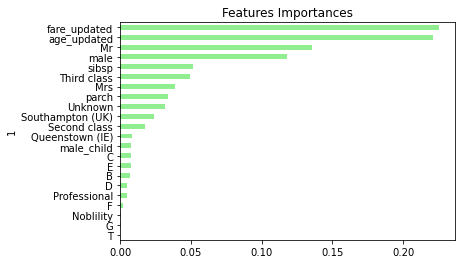

In [201]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

# Model 2
<h7> Optimising the model by increasing the number of trees in the forest

### Fitting the random forest model

In [202]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=1000, random_state=78)

In [203]:
# Fitting the model
rf_model = rf_model.fit(X_train, y_train)

In [204]:
# Make predictions
predictions = rf_model.predict(X_test)

### Evaluate the models performance

In [205]:
# Confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=['Actual - Did not survive', 'Actual - Survived'], columns=['Predicted - Did not survive', 'Predicted - Survived']
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [206]:
# Displaying results
print(f"The balanced accuracy score of the model is {balanced_accuracy_score(y_test, predictions)}")
print(f"The accuracy score of the model is : {acc_score}")
print(f"")
print("Confusion Matrix")
display(cm_df)
print("Classification Report")
print(classification_report(y_test, predictions))

The balanced accuracy score of the model is 0.786423645320197
The accuracy score of the model is : 0.8079268292682927

Confusion Matrix


,Predicted - Did not survive,Predicted - Survived
Actual - Did not survive,178,25
Actual - Survived,38,87


Classification Report
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       203
           1       0.78      0.70      0.73       125

    accuracy                           0.81       328
   macro avg       0.80      0.79      0.79       328
weighted avg       0.81      0.81      0.81       328



### Feature importance

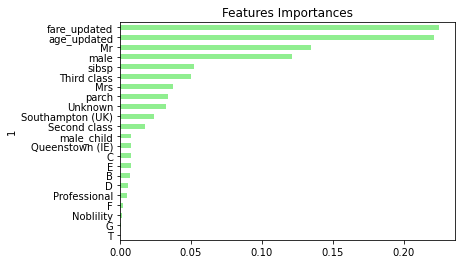

In [207]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

# Model 3 
<h7> Optomisation includes increasing the number of trees in the forest

### Fitting the random forest model

In [208]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=2000, random_state=78)

In [209]:
# Fitting the model
rf_model = rf_model.fit(X_train, y_train)

In [210]:
# Make predictions
predictions = rf_model.predict(X_test)

### Evaluate the models performance

In [211]:
# Confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=['Actual - Did not survive', 'Actual - Survived'], columns=['Predicted - Did not survive', 'Predicted - Survived']
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [212]:
# Displaying results
print(f"The balanced accuracy score of the model is {balanced_accuracy_score(y_test, predictions)}")
print(f"The accuracy score of the model is : {acc_score}")
print(f"")
print("Confusion Matrix")
display(cm_df)
print("Classification Report")
print(classification_report(y_test, predictions))

The balanced accuracy score of the model is 0.783960591133005
The accuracy score of the model is : 0.8048780487804879

Confusion Matrix


,Predicted - Did not survive,Predicted - Survived
Actual - Did not survive,177,26
Actual - Survived,38,87


Classification Report
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       203
           1       0.77      0.70      0.73       125

    accuracy                           0.80       328
   macro avg       0.80      0.78      0.79       328
weighted avg       0.80      0.80      0.80       328



### Feature importance

In [213]:
# Assigning feature imprtorance to a value
importances = rf_model.feature_importances_
# Sort features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.22622821418453057, 'fare_updated'),
 (0.2205880640890154, 'age_updated'),
 (0.13470741521823482, 'Mr'),
 (0.1209598485110751, 'male'),
 (0.052086770402732956, 'sibsp'),
 (0.04913231962008551, 'Third class'),
 (0.03693776065146311, 'Mrs'),
 (0.03381589678067178, 'parch'),
 (0.03212331733278392, 'Unknown'),
 (0.023895548245539213, 'Southampton (UK)'),
 (0.01752376637916921, 'Second class'),
 (0.008231267772075708, 'Queenstown (IE)'),
 (0.007766889867782075, 'male_child'),
 (0.007698344892728581, 'C'),
 (0.007383323437582364, 'E'),
 (0.006632720504643159, 'B'),
 (0.005256200430330175, 'D'),
 (0.004742001250086714, 'Professional'),
 (0.002411262766283767, 'F'),
 (0.0010308296036273161, 'Noblility'),
 (0.0008482380595585795, 'G'),
 (0.0, 'T')]

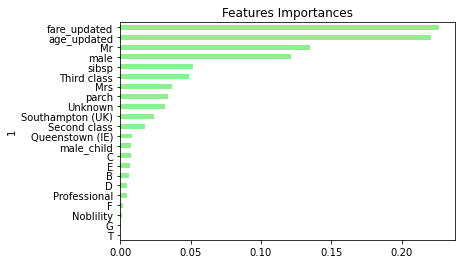

In [214]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)